## Principal component analysis of reef characteristics
This notebook is devoted to a principal component analysis to see what parameters of reef environment and bleaching may be grouped, and then to see whether reefs will cluster in a way which allows useful subsets to be created.

In [17]:
%matplotlib notebook

# This code section is largely a duplicate of the data input in the
# Bleaching_Project_Data_Setup notebook, with fewer comments.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
# from mytools import principal_component as pc
# functions moved so this project is self-contained:
import principal_component as pc
# Now read our data for reef cell locations.
# A copy of the data is in this repository.  The reference copy is in
# my Coral-Model-Data repository in the ProjectionsPaper directory.
mat_data = sio.loadmat('../data/ESM2M_SSTR_JD.mat')
#print(mat_data)

try:
    cells
except NameError:
    # do nothing, it's okay not to have cells yet
    pass
else:
    # Clear the variable so we don't get carryover from earlier tests. 
    cells = cells.iloc[0:0]
# Put the lat/lon columns directly into a data frame.  Note that they are stored
# with longitude first in the incoming data. 
cells = pd.DataFrame(mat_data['ESM2M_reefs_JD'], columns=['Lon', 'Lat'])
# Put in a random variable for testing
# cells['Rand'] = np.random.uniform(low=-10, high=10, size=len(modelBleaching))

cells['abs_lat'] = abs(cells['Lat'])

# It makes more sense to have longitude have a break at 0 than at +-180, since the latter is in the midddle of a coral area.
cells['Lon'] = cells['Lon']-180*(np.sign(cells['Lon'])-1)

# Now add bleaching counts from a specific run.
bleach_data = sio.loadmat('../data/HughesCompEvents_selV_rcp60E=1OA=1.mat')
# Put the bleaching counts into a data frame.
modelBleaching = pd.DataFrame(bleach_data['events80_2016'])
modelBleaching.rename(columns={0: 'Events'}, inplace=True)

# Really an output rather than an input, but try it...
cells['Events'] = modelBleaching['Events']

# Now get 1861-1950 SST mean and variance for each reef
sst = mat_data['SSTR_2M26_JD']
del mat_data  # this is big and not used again.
sst_mean = np.mean(sst, axis=1)
sst_var = np.var(sst, axis=1)
cells['SST'] = sst_mean
cells['variance'] = sst_var
print(cells.head())
all_names = list(cells)

     Lon        Lat    abs_lat  Events        SST  variance
0  180.5 -19.145246  19.145246       2  26.051836  2.952026
1  180.5 -18.311912  18.311912       2  26.373503  2.654303
2  180.5 -17.500333  17.500333       2  26.622993  2.420091
3  180.5 -16.710136  16.710136       1  26.928833  2.224938
4  180.5 -15.940584  15.940584       1  27.229943  1.902959


## Question:
Does it make sense to include Events (the variable we want to predict) in this analysis, or not?
How do we determine which variables are the best independent predictors of Events, rather than just of each other?

In [18]:
print('PCA including signed and unsigned latitude:')
[eigenval, eigenvec, pct_acct, loadings, sorted_names] = pc.pca(np.asmatrix(cells),
     all_names, standardize=True, sort=True)
print('Sorted names:\n', sorted_names)
print('Orig names:  \n', all_names)
print('Eigenvalues:\n', eigenval)
print('Eigenvectors:\n', eigenvec)
print('Variance accounted for by each component:\n', pct_acct)
print('Component loadings:\n', loadings)

PCA including signed and unsigned latitude:
Sorted names:
 ['Lon' 'Lat' 'abs_lat' 'Events' 'SST' 'variance']
Orig names:  
 ['Lon', 'Lat', 'abs_lat', 'Events', 'SST', 'variance']
Eigenvalues:
 [2.51298414 1.12226457 1.05498056 0.84291328 0.2786472  0.18821025]
Eigenvectors:
 [[ 2.17600522e-01  5.42475262e-01 -6.07036173e-01  3.79429386e-01
  -3.81822433e-01  1.10751087e-02]
 [ 1.45450278e-01 -3.96278289e-01 -7.44983685e-01 -4.43089954e-01
   2.64596591e-01  2.16097136e-02]
 [ 5.83445464e-01  5.53094548e-02  1.25608102e-01  1.46204328e-02
   2.03466830e-01 -7.74042861e-01]
 [-2.29030513e-01 -5.91684321e-01 -1.64865240e-01  7.19875942e-01
  -3.05922134e-04 -2.28150555e-01]
 [-5.47676012e-01  2.27132112e-02 -9.85666072e-02 -3.57069283e-01
  -4.94332676e-01 -5.63876274e-01]
 [ 4.88550539e-01 -4.41609269e-01  1.54379643e-01 -1.17350040e-01
  -7.06000450e-01  1.73950807e-01]]
Variance accounted for by each component:
 [41.88306902 18.70440955 17.58300929 14.04855459  4.64412     3.13683753]


In [25]:
import copy
print('PCA including only unsigned latitude:')
print('Note that variable names do NOT correspond to the columns below, which are based on PCs.')
print('all names:', all_names)
# Without deepcopy, removing names from the list affects the original.
reduced_names = copy.deepcopy(all_names)
reduced_names.remove('Lat')
reduced_names.remove('Lon')
reduced_names.remove('Events')
[eigenval, eigenvec, pct_acct, loadings, sorted_names] = pc.pca(np.asmatrix(cells[reduced_names]),
     reduced_names, standardize=True, sort=True)
print('Names:\n', sorted_names)
print('Eigenvalues:\n', eigenval)
print('Eigenvectors:\n', eigenvec)
print('Variance accounted for by each component:\n', pct_acct)
print('Component loadings:\n', loadings)


PCA including only unsigned latitude:
Note that variable names do NOT correspond to the columns below, which are based on PCs.
all names: ['Lon', 'Lat', 'abs_lat', 'Events', 'SST', 'variance']
Names:
 ['abs_lat' 'variance' 'SST']
Eigenvalues:
 [2.33160811 0.43911775 0.22927415]
Eigenvectors:
 [[ 0.59956931 -0.75443309 -0.26710925]
 [ 0.54645254  0.14206258  0.82535316]
 [-0.58472751 -0.64081895  0.49743824]]
Variance accounted for by each component:
 [77.72027019 14.63725817  7.64247164]
Component loadings:
 [[ 0.9155186  -0.49993233 -0.1278988 ]
 [ 0.8344114   0.09413913  0.39520039]
 [-0.89285576 -0.42464483  0.23818627]]


<IPython.core.display.Javascript object>


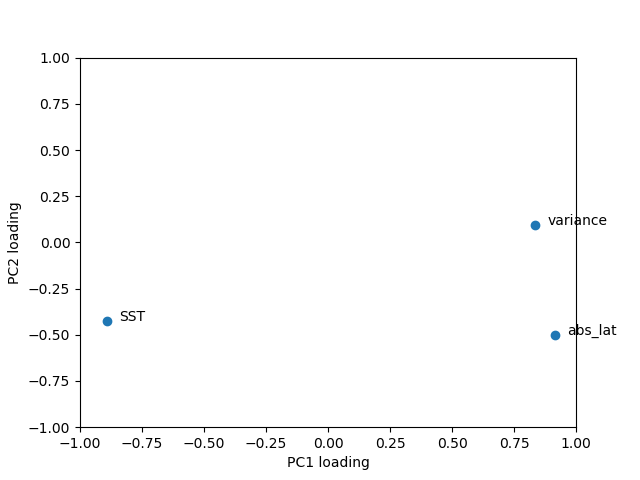

array(['abs_lat', 'variance', 'SST'], dtype='<U8')

In [26]:
# Now look at factor loadings for the reduced list
# A = V (sqrt(Lambda))
# V = eigenvectors = eigenvec
# Lambda = eigenvalue matrix = eigenval
A = np.matmul(eigenvec, np.diag(eigenval)**0.5)
# A now contains the loadings for PC1 in the first row, and so on.
A
plt.figure()
plt.plot(A[:, 0], A[:, 1], 'o')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel('PC1 loading')
plt.ylabel('PC2 loading')
for i, txt in enumerate(sorted_names):
    plt.text(A[i,0]+0.05,A[i,1],txt)
sorted_names

Above, **how is it** that Longitude has the highest variance explained (62.6%), but it has the lowest weighting in the PC1 loading axis?  Tom Connolly pointed out that longitude doesn't mean anything numerically, so it may not be suitable for this analysis, even though corals are sometimes segregated by longitude (e.g. Atlantic vs. Pacific).

<IPython.core.display.Javascript object>


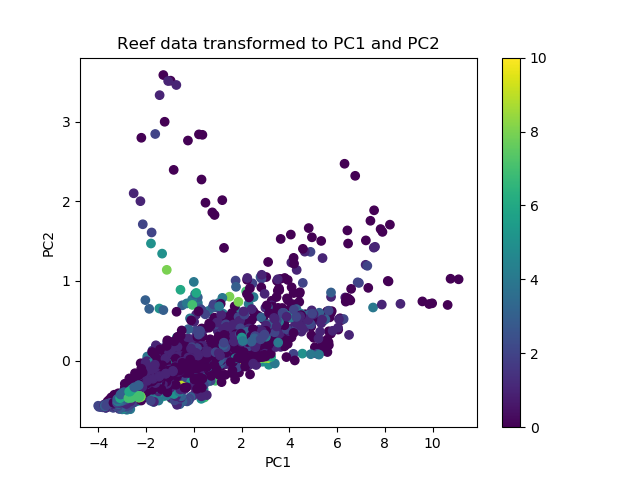

In [27]:
# Now show all reefs transformed to PC1 and PC2
# Convert each observation (reef) to a point in PC1, PC2 coordinates.
# WARNING: data have not been sorted, eigen* have!
data = np.asarray(cells[reduced_names])
data_normalized = (data - np.mean(data, 0)) / np.std(data, 0, ddof=1)

pc1 = eigenval[0]*np.sum(data_normalized * eigenvec[0], 1)
pc2 = eigenval[1]*np.sum(data_normalized * eigenvec[1], 1)
plt.figure()
#plt.scatter(pc1, pc2, c=cells['Lon'])
plt.scatter(pc1, pc2, c=cells['Events'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Reef data transformed to PC1 and PC2');
plt.colorbar()

## Conclusions
After eliminating variables which don't make sense in this analysis, there are so few that PCA isn't useful.  I'll switch to another notebook and just try scatterplots.  I'll do it for the world and for regional groups.